# Handwritten digit classification 


In [18]:
import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold


## 0. load data

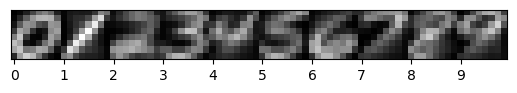

In [2]:
# load the data & plot the means
train_data, train_labels, test_data, test_labels = data.load_all_data_from_zip('a3digits.zip','loaded_data/')
# for i in [train_data, train_labels, test_data, test_labels]:
#     print(i.shape)

def plot_means(train_data, train_labels):
    means = []
    for i in range(0, 10):
        i_digits = data.get_digits_by_label(train_data, train_labels, i)
        # Compute mean of class i
        means.append(np.mean(i_digits, axis=0).reshape(8,8))

    # Plot all means on same axis
    all_concat = np.concatenate(means, 1)
    plt.imshow(all_concat, cmap='gray')
    plt.yticks([])
    plt.xticks(ticks=np.arange(0,73,8),labels=range(10))
    plt.show()

plot_means(train_data, train_labels)

## 1. Conditional Gaussian Classifier Training
### 1.a classifier implementation

In [3]:
#TODO: ADD MATHEMATICAL INTERPRETATIONS 

# classifier implementation 

def compute_mean_mles(train_data, train_labels):
    '''
    make sure the inputs are both np.arrays
    Compute the mean estimate for each digit class

    Should return a numpy array of size (10,64)
    The ith row will correspond to the mean estimate for digit class i
    '''
    means = np.zeros((10, 64))
    # Compute means
    for k in range(10):
        class_k = train_data[train_labels == k]
        means[k] = np.mean(class_k, axis=0)
    return means # shape: (10,64); row 1 being 0 all the way to row 10 being 9

def compute_sigma_mles(train_data, train_labels):
    '''
    Compute the covariance estimate for each digit class

    Should return a three dimensional numpy array of shape (10, 64, 64)
    consisting of a covariance matrix for each digit class 
    '''
    covariances = np.zeros((10, 64, 64))
    # Compute covariances
    means = compute_mean_mles(train_data,train_labels) #(10,64)
    for k in range(10):
        class_k = train_data[train_labels==k]
        N = class_k.shape[0] # 700 cases for every digit 
        cov = ((class_k-means[k]).T @ (class_k-means[k])) / N + 0.01*np.eye(64) # (64,64)
        covariances[k] = cov 
    return covariances

def plot_cov_diagonal(covariances):
    # Plot the log-diagonal of each covariance matrix side by side
    fig,ax = plt.subplots(1,10,figsize=(15,1.5))
    for i in range(10):
        cov_diag = np.diag(covariances[i])
        log_cov_diag = np.log(cov_diag) #(64,)
        sns.heatmap(log_cov_diag.reshape(8,8), ax=ax[i], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
        ax[i].set_title(f'{i}', fontsize=8)
    plt.tight_layout()
    plt.show()

def generative_likelihood(digits, means, covariances):
    '''
    digits: basically the training data (7000*64)
    means: the means of the 64 features of 10 digits, fro 0 to 9 (10*64)
    covariancs: the cov matrices of the 10 digits, from 0 to 9 (10*64*64)

    Compute the generative (negative) log-likelihood:
        -log p(x|y,mu,Sigma)

    Should return an n x 10 numpy array (n = digits.shape[0]; for training set it is 7000)
    '''
    n,d = digits.shape # (7000,64) for training set
    neg_log_likelihoods = np.zeros((n,10))

    for i in range(10):
        mu = means[i] # (64,)
        cov = covariances[i] # (64,64)
        diff = digits - mu # (7000,64)
        
        # take the log on the gaussian pdf 
        # for the exponential term (-1/2 (x-mu)T cov-1 (x-mu)), rewrite it to the sum of (x-mu) @ cov-1 * (x-mu)
        log_pdf = -d*np.log(2*np.pi)/2 - np.log(np.linalg.det(cov))/2 - np.sum(diff @ np.linalg.inv(cov) * diff, axis=1)/2 # (7000,)
        neg_log_likelihoods[:,i] = log_pdf

    return neg_log_likelihoods # (7000,10)

def conditional_likelihood(digits, means, covariances):
    '''
    Compute the (negative) conditional likelihood:

        (neg) log p(y|x, mu, Sigma)

    This should be a numpy array of shape (n, 10); for training set, n = 7000; it should also be generalized to/usable for any test point
    Where n is the number of datapoints and 10 corresponds to each digit class
    '''

    neg_log_likelihoods = generative_likelihood(digits,means,covariances) #(7000*10) for training set
    prior = 1/10 # scalar 
    
    # post = prior * likelihood, normalized by the sum 
    likelihoods = np.exp(-neg_log_likelihoods)
    protopost = prior * likelihoods
    normalization = np.sum(protopost, axis=1)[:,np.newaxis]
    post = protopost / normalization
    # return NLL
    return -np.log(post)

def avg_conditional_likelihood(digits, labels, means, covariances):
    '''
    Compute the average conditional likelihood over the true class labels

        AVG( log p(y_i|x_i, mu, Sigma) )

    i.e. the average log likelihood that the model assigns to the correct class label
    '''
    cond_nll = conditional_likelihood(digits, means, covariances) #(n,10)
    avg_nll = np.zeros(10) #(10,)
    for k in range(10):
        class_k = cond_nll[labels==k]
        mean = np.mean(class_k[:,k])
        avg_nll[k] = mean
    return avg_nll

def classify_data(digits, means, covariances):
    '''
    Classify new points by taking the most likely posterior class

    digits here can be a test set with arbitrary test points (n)
    '''
    cond_nll = conditional_likelihood(digits, means, covariances)
    # Compute and return the most likely class
    preds = np.argmax(cond_nll, axis=1) #(n,)
    return preds 

def train_test_avg_nll(train_data, train_labels, test_data, test_labels):
    # Fit the model
    means = compute_mean_mles(train_data, train_labels)
    covariances = compute_sigma_mles(train_data, train_labels)
 
    train_avg_nll = avg_conditional_likelihood(train_data,train_labels,means,covariances)
    test_avg_nll = avg_conditional_likelihood(test_data,test_labels,means,covariances)

    return pd.DataFrame([train_avg_nll,test_avg_nll], index=['train','test'], columns=[i for i in range(10)])

def eval(train_data, train_labels, test_data, test_labels):
    # Fit the model
    means = compute_mean_mles(train_data, train_labels)
    covariances = compute_sigma_mles(train_data, train_labels)

    # evaluations 
    preds_train = classify_data(train_data,means,covariances)
    preds_test = classify_data(test_data,means,covariances)

    train_acc = np.sum(preds_train==train_labels) / len(train_labels)
    test_acc = np.sum(preds_test==test_labels) / len(test_labels)
    return train_acc, test_acc

### 1.b plot log diagonal elements for the cov matrix for each class (0~9)


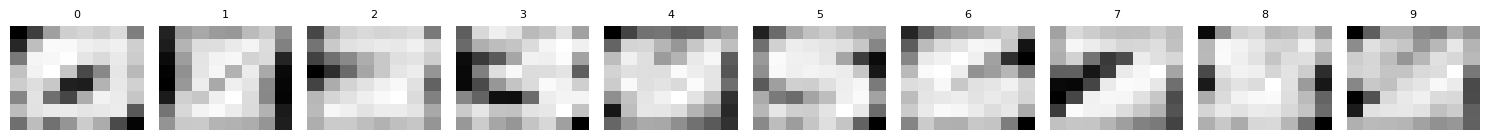

In [4]:
covariances = compute_sigma_mles(train_data,train_labels)
plot_cov_diagonal(covariances)

### 1.c compute the average conditional log-likelihood on both the train and test set

In [5]:
train_test_avg_nll(train_data, train_labels, test_data, test_labels)

,0,1,2,3,4,5,6,7,8,9
train,170.425688,129.811592,115.880479,118.929064,100.923172,113.610387,195.700517,123.177629,99.269592,121.756419
test,164.074030,124.916090,116.803622,116.901135,98.828264,110.687617,197.198026,122.924547,99.125737,120.418343


### 1.d train and test accuracy

In [6]:
train_acc, test_acc = eval(train_data, train_labels, test_data, test_labels)
print(f'train accuracy: {train_acc}; test accuracy: {test_acc}')

train accuracy: 0.9814285714285714; test accuracy: 0.97275


### 1.e visualization: in the test set, show both the correct and incorrect classifications 

In [7]:
def find_correct_incorrect(train_data, train_labels, test_data, test_labels, clf):
    # Fit the model
    if clf=='conditional_gaussian_classifier':
        means = compute_mean_mles(train_data, train_labels)
        covariances = compute_sigma_mles(train_data, train_labels)
        # predict test
        preds = classify_data(test_data,means,covariances)
    elif clf=='naive_bayes_classifier': # functions are defined in the next part
        eta = compute_parameters_nbc(train_data, train_labels)
        # predict test
        preds = classify_data_nbc(test_data,eta)
    else:
        raise ValueError("Invalid classifier specified. Use 'cgc' for Gaussian or 'nbc' for Naive Bayes.")

    correct_mask = test_labels == preds
    incorrect_mask = test_labels != preds

    # find the first 5 correct/incorrect
    correct_idx = np.where(correct_mask)[0][:5] 
    incorrect_idx = np.where(incorrect_mask)[0][:5]

    # make sure test labels are int (not float; just for aesthetic purpose)
    test_labels = test_labels.astype(int)
    
    # plot and print labels for correct preds
    correct_data = test_data[correct_idx]
    true_label_for_correct_data = test_labels[correct_idx]
    pred_label_for_correct_data = preds[correct_idx]
    fig, ax = plt.subplots(1,5,figsize = (10,2))
    for i in range(5):
        sns.heatmap(correct_data[i].reshape(8,8), ax = ax[i], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
        ax[i].set_xlabel(f'true: {true_label_for_correct_data[i]}; pred:{pred_label_for_correct_data[i]}')
    plt.suptitle('correct preds')
    plt.tight_layout()
    plt.show()

    # plot and print labels for incorrect preds
    incorrect_data = test_data[incorrect_idx]
    true_label_for_incorrect_data = test_labels[incorrect_idx]
    pred_label_for_incorrect_data = preds[incorrect_idx]
    fig, ax = plt.subplots(1,5,figsize = (10,2))
    for i in range(5):
        sns.heatmap(incorrect_data[i].reshape(8,8), ax = ax[i], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
        ax[i].set_xlabel(f'true: {true_label_for_incorrect_data[i]}; pred:{pred_label_for_incorrect_data[i]}')
    plt.suptitle('incorrect preds')
    plt.tight_layout()
    plt.show()

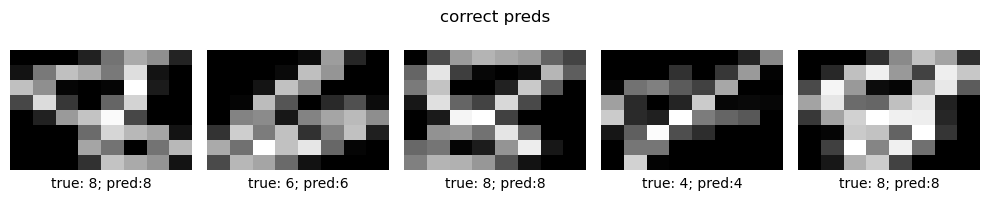

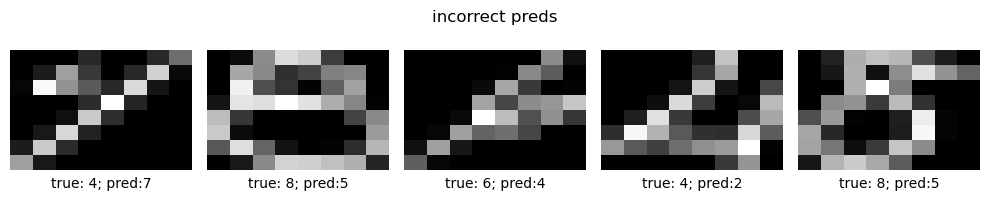

In [8]:
find_correct_incorrect(train_data, train_labels, test_data, test_labels, 
                       clf='conditional_gaussian_classifier')

## 2 Naive Bayes Classifier
### 2.a. classifier implementation

In [9]:
#TODO: ADD MATHEMATICAL INTERPRETATIONS 

# classifier implementation
def binarize_data_nbc(pixel_values):
    '''
    Binarize the data by thresholding around 0.5
    '''
    return np.where(pixel_values > 0.5, 1.0, 0.0)

def compute_parameters_nbc(train_data, train_labels):
    '''
    Compute the eta MAP estimate/MLE with augmented data

    You should return a numpy array of shape (10, 64)
    where the ith row corresponds to the ith digit class.
    '''
    train_data = binarize_data_nbc(train_data)
    eta = np.zeros((10, 64))

    # goal: calculate the MAP (eta) of each bernoulli feature for each digit 
    # location is denoted as (k,j) where k is digit (0~9) and j is binarized feature (1~64)
    # prior: p(eta_kj) = Beta(2,2)
    # likelihood for a single b feature p(b_j = 1 | y = k) = eta_kj
    # likewise, if b_j = 0, p(b_j = 0 | y = k) = (1-eta_kj)
    # so for an image that has 64 features, the aggregated likelihood p(b|y=k,eta) = prod^64_j=1 eta_kj^{b_j} (1-eta_kj)^(1-{b_j})
    # so whenever b_j is 1, we multiply the prod by eta_kj
    # and if b_j is 0, we multiply the prod by (1-eta_kj)

    # after some calculation, we reach the result of posterior
    # process see Lec7 slides 44,45
    # long story short, the posterior eta_hat_MAP = (S_kj + a - 1) / (N_k + a + b - 2)
    # S_kj is the sum of jth B feature being 1 for class k (in this case we get 700 imgs each)
    # N_k is the total case of class k (so = 700)
    # also in this problem, we have a = b = 2
    # therefore, the MAP is (S_kj + 1) / (N_k + 2)

    for k in range(10):
        class_k = train_data[train_labels == k]
        # S_kj (for class k at jth b feature) is essentially just the sum of each feature across all (700) samples (axis=0)
        # because they are either 1 or 0, that's why we just need to sum them up
        N_k = class_k.shape[0]
        eta[k] = (np.sum(class_k, axis=0) + 1) / (N_k + 2)      
    return eta

def plot_images_nbc(class_images):
    '''
    Plot each of the images corresponding to each class side by side in grayscale
    class_images: the eta (10*64) from above
    '''
    fig,ax = plt.subplots(1,10,figsize=(15,1.5))
    for i in range(10):
        img_i = class_images[i]
        sns.heatmap(img_i.reshape(8,8), ax = ax[i], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
        ax[i].set_title(f'{i}', fontsize=8)
    plt.tight_layout()
    plt.show()

def generate_new_data_nbc(eta):
    '''
    Sample a new data point from your generative distribution p(x|y,theta) for
    each value of y in the range 0...10

    Plot these values
    '''
    np.random.seed(69)
    generated_data = np.zeros((10, 64))

    for k in range(10):
        generated_data[k] = np.random.binomial(1,eta[k])

    fig, ax = plt.subplots(1,10,figsize=(15,1.5))
    for i in range(10):
        sns.heatmap(generated_data[i].reshape(8,8), ax=ax[i], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
        ax[i].set_title(f'{i}', fontsize=8)
    plt.tight_layout()
    plt.show()

def generative_likelihood_nbc(bin_digits, eta):
    '''
    Compute the generative (negative) log-likelihood:
        -log p(x|y, eta)

    Should return an n x 10 numpy array 
    '''
    # Clip eta to avoid log(0) errors
    eta = np.clip(eta, 1e-10, 1 - 1e-10)

    # p(b|y=k, eta) = Prod(j=1~d) eta_kj^bj (1-eta_kj)^(1-bj)
    #     # log p = log(eta) * # of (bj=1) + log(1-eta) * # of (bj=0)
    #     # in matrix form: 
    #     # bin_digits @ log(eta) + (1-bin_digits) @ log(1-eta)
    #     # since we are doing NLL, flip all the plus signs 

    neg_log_likelihoods = - bin_digits @ np.log(eta.T) - (1-bin_digits) @ np.log((1-eta).T)
    return neg_log_likelihoods #(n,10)

def conditional_likelihood_nbc(bin_digits, eta):
    '''
    Compute the conditional likelihood:

        log p(y|x, eta)

    This should be a numpy array of shape (n, 10)
    Where n is the number of datapoints and 10 corresponds to each digit class
    '''
    # do the same thing as what have been done in gaussian clf
    neg_log_likelihoods = generative_likelihood_nbc(bin_digits, eta) #(n,10)
    prior = 1/10 # scalar 
    likelihoods = np.exp(-neg_log_likelihoods)
    protopost = prior * likelihoods

    if bin_digits.ndim==1: # if theres only one case 
        normalization = np.sum(protopost)
    else:
        normalization = np.sum(protopost, axis=1)[:,np.newaxis]
    post = protopost / normalization
    return post #(n,10)


def avg_conditional_likelihood_nbc(bin_digits, labels, eta):
    '''
    Compute the average conditional likelihood over the true class labels

        AVG( log p(y_i|x_i, eta) )

    i.e. the average log likelihood that the model assigns to the correct class label
    '''
    cond_nll = conditional_likelihood_nbc(bin_digits, eta)

    avg_nll = np.zeros(10) #(10,)
    for k in range(10):
        class_k = cond_nll[labels==k]
        mean = np.mean(class_k[:,k])
        avg_nll[k] = mean
    return avg_nll

def classify_data_nbc(bin_digits, eta):
    '''
    Classify new points by taking the most likely posterior class
    '''
    cond_nll = conditional_likelihood_nbc(bin_digits, eta) ##(n,10)

    # Compute and return the most likely class
    if bin_digits.ndim==1: # if there's only one test case
        preds = np.argmax(cond_nll) #(1,)
    else:
        preds = np.argmax(cond_nll, axis=1) #(n,)
    return preds 

def train_test_avg_nll_nbc(train_data, train_labels, test_data, test_labels):
    # Fit the model
    train_data = binarize_data_nbc(train_data)
    test_data = binarize_data_nbc(test_data)
    eta = compute_parameters_nbc(train_data, train_labels)

    train_avg_nll = avg_conditional_likelihood_nbc(train_data,train_labels,eta)
    test_avg_nll = avg_conditional_likelihood_nbc(test_data,test_labels,eta)

    return pd.DataFrame([train_avg_nll,test_avg_nll], index=['train','test'], columns=[i for i in range(10)])

def eval_nbc(train_data, train_labels, test_data, test_labels):
    # Fit the model
    train_data = binarize_data_nbc(train_data)
    test_data = binarize_data_nbc(test_data)
    eta = compute_parameters_nbc(train_data, train_labels)

    # evaluations 
    preds_train = classify_data_nbc(train_data,eta)
    preds_test = classify_data_nbc(test_data,eta)

    train_acc = np.sum(preds_train==train_labels) / len(train_labels)
    test_acc = np.sum(preds_test==test_labels) / len(test_labels)
    return train_acc, test_acc

### 2.b binarize train data

[[0.   0.   0.   0.   0.   0.   0.15 0.66]
 [0.   0.   0.   0.   0.   0.25 0.7  0.2 ]
 [0.   0.   0.   0.   0.42 0.54 0.01 0.  ]
 [0.   0.   0.04 0.6  0.45 0.   0.   0.  ]
 [0.   0.09 0.71 0.24 0.   0.   0.   0.  ]
 [0.14 0.7  0.09 0.22 0.63 0.8  0.52 0.  ]
 [0.7  0.11 0.1  0.76 0.27 0.44 0.31 0.  ]
 [0.5  0.44 0.62 0.64 0.39 0.08 0.   0.  ]] 

[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]] 



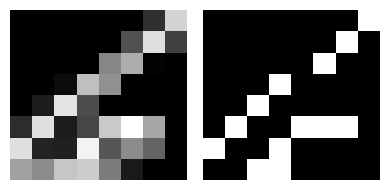

In [10]:
binarized_train_data = binarize_data_nbc(train_data)

# visualize to check
original_binary = [train_data[0].reshape(8,8),binarized_train_data[0].reshape(8,8)]
fig, ax = plt.subplots(1,2, figsize=(4,2))
for i in range(2):
    print(original_binary[i],'\n')
    sns.heatmap(original_binary[i].reshape(8,8), ax = ax[i], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
plt.tight_layout()
plt.show()

### 2.c.i train a bernoulli naive bayes classifier using MAP 

In [11]:
eta = compute_parameters_nbc(train_data, train_labels)
eta.shape

(10, 64)

### 2.c.ii prior as pseudo counts
(still working on it; will also need to explain why adding these two special cases (refer to A3 document))

In [12]:
# TODO 
def compute_parameters_nbc_new(train_data, train_labels):
    '''
    Instead of explicitly considering the Beta distribution prior in the Bernoulli likelihood model, 
    you can add two training cases to your data set for each class, 
    one of which has every pixels OFF and the other has every pixels ON. 
    Make sure you understand why this is equivalent to using a prior.
    '''    
    return None
train_data = binarize_data_nbc(train_data)
# TODO: reasoning

### 2.d plot eta_k (without the 2 extra cases) 

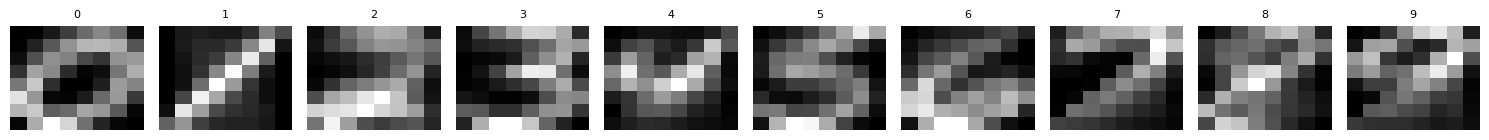

In [13]:
plot_images_nbc(eta)

### 2.e sample one new data point using the gen model for each class

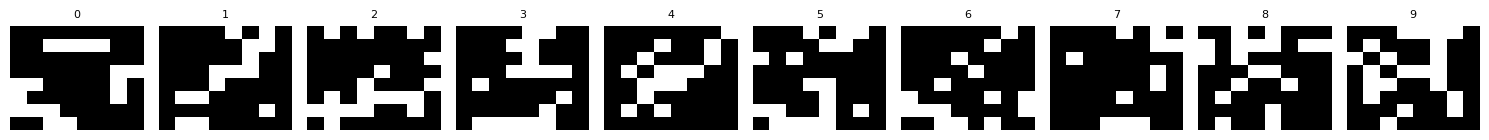

In [14]:
generate_new_data_nbc(eta)

### 2.f average conditional log likelihood 

In [15]:
train_test_avg_nll_nbc(train_data, train_labels, test_data, test_labels)

,0,1,2,3,4,5,6,7,8,9
train,0.878137,0.76552,0.722712,0.781650,0.758870,0.697034,0.832115,0.729780,0.655897,0.659850
test,0.846944,0.78222,0.703276,0.750858,0.747925,0.691121,0.816955,0.733048,0.677774,0.645347


### 2.g train and test accuracy

In [16]:
train_acc_nbc, test_acc_nbc = eval_nbc(train_data, train_labels, test_data, test_labels)
print(f'train accuracy: {train_acc_nbc}; test accuracy: {test_acc_nbc}')

train accuracy: 0.7741428571428571; test accuracy: 0.76425


### 2.h visualization: in the test set, show both the correct and incorrect classifications 

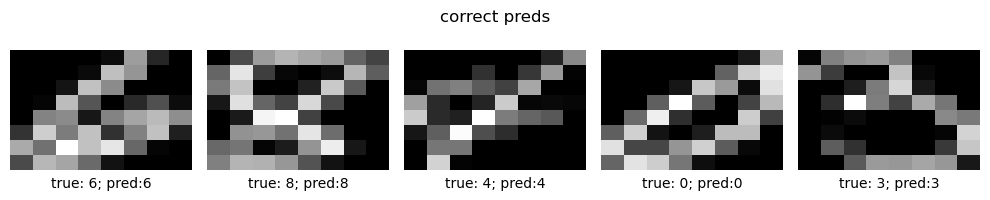

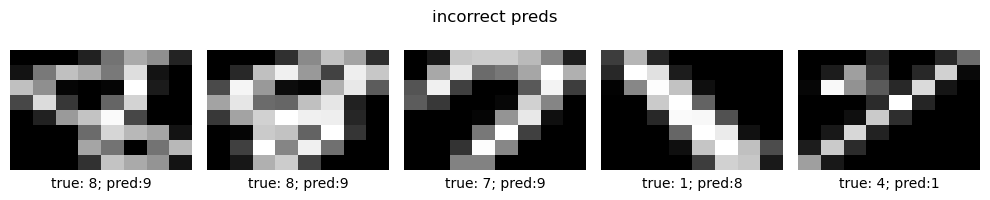

In [17]:
find_correct_incorrect(train_data, train_labels, test_data, test_labels, 
                       clf='naive_bayes_classifier')